In [ ]:
import numpy as np
import networkx as nx
import random
import gym
import tensorflow as tf
from collections import deque
import sys
import pickle



class DAGJobs():
    def __init__(self, num_tasks, num_vms):
        self.num_tasks = num_tasks
        self.num_vms = num_vms
        self.dag = self.generate_dag()
        self.task_requirements = np.random.randint(1000, 5000, size=num_tasks)
        self.vm_processing_power = np.random.randint(1000, 2500, size=num_vms)
        self.execution_times = np.zeros((num_tasks, num_vms))
        for t in range(num_tasks):
            for v in range(num_vms):
                self.execution_times[t][v] = self.task_requirements[t] / self.vm_processing_power[v]
        self.L = np.random.uniform(0.1, 0.5, size=num_vms)
        self.B = np.random.uniform(100, 500, size=(num_vms, num_vms))
        self.data_transfer = np.random.randint(10, 100, size=(num_tasks, num_tasks))

    def generate_dag(self):
        dag = nx.gnp_random_graph(self.num_tasks, 0.2, directed=True)
        dag = nx.DiGraph([(u, v) for u, v in dag.edges() if u < v])
        return dag

    def compute_rank(self):
        rank = {}
        for task in reversed(list(nx.topological_sort(self.dag))):
            children = list(self.dag.successors(task))
            if not children:
                rank[task] = np.mean(self.execution_times[task])
            else:
                max_child_rank = 0
                for child in children:
                    child_rank = rank[child]
                    avg_comm_cost = np.mean([self.get_communication_cost(task, child, vm1, vm2)
                                            for vm1 in range(self.num_vms)
                                            for vm2 in range(self.num_vms)])
                    max_child_rank = max(max_child_rank, child_rank + avg_comm_cost)
                rank[task] = np.mean(self.execution_times[task]) + max_child_rank
        sorted_tasks = sorted(rank.keys(), key=lambda x: rank[x], reverse=True)
        return sorted_tasks, rank

    def get_task_order(self):
        return self.compute_rank()

    def get_execution_time_matrix(self):
        return self.execution_times

    def get_communication_cost(self, task_i, task_k, vm_m, vm_n):
        if vm_m == vm_n:
            return self.L[vm_m]
        return self.L[vm_m] + (self.data_transfer[task_i][task_k] / self.B[vm_m][vm_n])

    def get_average_case_execution_time(self):
        total_execution_time = 0

        # Loop through each task
        for task_id in range(self.num_tasks):
            # Calculate task execution time considering the communication cost with its predecessors
            execution_time = np.mean(self.execution_times[task_id])  # Task execution time

            # Add communication cost with its dependencies
            dependencies = list(self.dag.predecessors(task_id))  # Accessing the correct dag instance
            comm_cost = 0
            for dep_task in dependencies:
                # Compute communication cost for each dependency using the correct method
                comm_cost += np.mean([self.get_communication_cost(dep_task, task_id, vm1, vm2)
                                      for vm1 in range(self.num_vms) for vm2 in range(self.num_vms)])

            # Add communication time to the total execution time for the task
            total_execution_time += execution_time + comm_cost

        # Return the total execution time across all tasks
        return total_execution_time


class SchedulerBaseline:
    def __init__(self, jobs: DAGJobs):
        self.jobs = jobs
        self.num_tasks = jobs.num_tasks
        self.num_vms = jobs.num_vms
        self.execution_times = jobs.execution_times
        self.get_communication_cost = jobs.get_communication_cost
        self.dag = jobs.dag
        self.task_order, _ = jobs.compute_rank()
        self.latency = 1

    def compute_est(self, task_id, vm_id, task_completion_time, task_vm_mapping):
        preds = list(self.dag.predecessors(task_id))
        est = 0
        for pred in preds:
            pred_vm = task_vm_mapping.get(pred, None)
            comm_time = 0
            if pred_vm is not None:
                comm_time = self.get_communication_cost(pred, task_id, pred_vm, vm_id)
            est = max(est, task_completion_time.get(pred, 0) + comm_time) + self.latency
        return est

    def schedule(self, policy="fcfs"):
        vm_available_time = np.zeros(self.num_vms)
        task_completion_time = {}
        task_vm_mapping = {}
        schedule = []

        remaining_tasks = self.task_order.copy()

        while remaining_tasks:
            if policy == "max-min":
                candidates = []
                for task_id in remaining_tasks:
                    for vm in range(self.num_vms):
                        est = self.compute_est(task_id, vm, task_completion_time, task_vm_mapping)
                        eft = max(vm_available_time[vm], est) + self.execution_times[task_id][vm]
                        candidates.append((eft, task_id, vm))

                # Select the task-VM pair with the maximum of the minimum EFT
                eft, task_id, vm = max(candidates)
                exec_time = self.execution_times[task_id][vm]
                est = self.compute_est(task_id, vm, task_completion_time, task_vm_mapping)

            else:  # FCFS
                task_id = remaining_tasks[0]
                best_vm = None
                best_est = None
                earliest_start_time = float('inf')

                for vm in range(self.num_vms):
                    est = self.compute_est(task_id, vm, task_completion_time, task_vm_mapping)
                    ready_time = max(vm_available_time[vm], est)
                    if ready_time < earliest_start_time:
                        earliest_start_time = ready_time
                        best_vm = vm
                        best_est = est

                vm = best_vm
                est = best_est
                exec_time = self.execution_times[task_id][vm]
                eft = max(vm_available_time[vm], est) + exec_time

            # Update system states
            task_completion_time[task_id] = eft
            task_vm_mapping[task_id] = vm
            vm_available_time[vm] = eft
            schedule.append((task_id, vm, exec_time, est, eft))
            remaining_tasks.remove(task_id)

        makespan = max(vm_available_time)
        return makespan, schedule

    def fcfs_schedule(self):
        return self.schedule(policy="fcfs")

    def max_min_schedule(self):
        return self.schedule(policy="max-min")




class Scheduler(gym.Env):
    def __init__(self, num_tasks, num_vms):
        self.num_tasks = num_tasks
        self.num_vms = num_vms
        self.jobs = DAGJobs(num_tasks, num_vms)
        self.task_order, self.rank_values = self.jobs.compute_rank()
        self.schedule = []
        self.task_completion_time = np.zeros(num_tasks)
        self.vm_available_time = np.zeros(num_vms)
        self.best_finish_time = np.inf * np.ones(num_tasks)

    def reset(self):
        self.schedule.clear()
        self.task_completion_time.fill(0)
        self.vm_available_time.fill(0)
        self.best_finish_time.fill(np.inf)
        return self.get_state()

    def execute_task(self, task_id, vm_id):
        execution_time = self.jobs.execution_times[task_id][vm_id]
        dependencies = list(self.jobs.dag.predecessors(task_id))

        max_pred_finish = 0
        for pred in dependencies:
            pred_vm = self.schedule[pred][1] if pred < len(self.schedule) else 0
            comm_cost = self.jobs.get_communication_cost(pred, task_id, pred_vm, vm_id) if pred_vm != vm_id else self.jobs.L[vm_id]
            pred_finish = self.task_completion_time[pred] + comm_cost
            max_pred_finish = max(max_pred_finish, pred_finish)

        est = max(self.vm_available_time[vm_id], max_pred_finish)
        eft = est + execution_time

        self.task_completion_time[task_id] = eft
        self.vm_available_time[vm_id] = max(self.vm_available_time[vm_id], eft)
        self.schedule.append((task_id, vm_id, execution_time, est, eft))
        return execution_time

    def get_total_execution_time(self):
        return max(self.vm_available_time)

    def step(self, action):
        if len(self.schedule) >= self.num_tasks:
            return self.reset(), 0, True, {}

        task_id = self.task_order[len(self.schedule)]
        vm_id = action

        prev_makespan = self.get_total_execution_time()
        execution_time = self.execute_task(task_id, vm_id)
        new_makespan = self.get_total_execution_time()

        if execution_time != 0:
            reward = ((execution_time - (new_makespan - prev_makespan)) / execution_time) ** 3
        else:
            reward = 0
        reward = max(0, min(reward, 1))

        new_state = self.get_state()
        done = len(self.schedule) == self.num_tasks
        return new_state, reward, done, {}

    def update_episode_reward(self):
        total_execution_time = self.get_total_execution_time()
        return 500 * (1 / total_execution_time)

    def get_state(self):
        return np.concatenate((
            [len(self.schedule), self.num_tasks - len(self.schedule)],
            np.bincount([v for _, v, *_ in self.schedule], minlength=self.num_vms),
            self.vm_available_time
        ))


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99
        self.learning_rate = 0.00025
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(self.state_size,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        return random.randrange(self.action_size) if random.random() <= self.epsilon else np.argmax(self.model.predict(state.reshape(1, -1))[0])

    def replay(self, batch_size=32):
        batch = random.sample(self.memory, min(batch_size, len(self.memory)))
        for s, a, r, s_, d in batch:
            target = r + (not d) * self.gamma * np.amax(self.target_model.predict(s_.reshape(1, -1), verbose=0)[0])
            target_f = self.model.predict(s.reshape(1, -1), verbose=0)
            target_f[0][a] = target
            self.model.fit(s.reshape(1, -1), target_f, epochs=1, verbose=0, batch_size=16)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

num_tasks, num_vms = 100, 5
scheduler = Scheduler(num_tasks, num_vms)
state_size = 2 + num_vms + num_vms
agent = DQNAgent(state_size, state_size - num_vms - 2)

baseline = SchedulerBaseline(scheduler.jobs)

fcfs_time, fcfs_schedule = baseline.fcfs_schedule()
max_min_time, max_min_schedule = baseline.max_min_schedule()


print("\nBaseline Execution Times (with communication):")
print(f"FCFS: {fcfs_time:.2f}")
print(f"Max-Min: {max_min_time:.2f}")
print("\nTask-VM Execution Time Matrix (Seconds):")
print(scheduler.jobs.get_execution_time_matrix())

print("\nTask Rank Values:")
for task, rank in scheduler.rank_values.items():
    print(f"Task {task}: Rank = {rank:.2f}")

print("\nTask Order (Based on Rank Calculation):")
print(scheduler.task_order)

avg_execution_time = scheduler.jobs.get_average_case_execution_time()
print(f"\nAverage Case Execution Time (Tasks running on average VM speed): {avg_execution_time:.2f} seconds\n")


episodes = 250
best_execution_time = float('inf')
execution_times_history = []
episode_rewards = []

for e in range(episodes):
    state = scheduler.reset()
    done = False
    total_reward = 0
    step_count = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = scheduler.step(action)

        # Add decaying factor to simulate gradual reward decrease
        decay_factor = 1 - min(e / episodes, 1.0)
        reward *= decay_factor

        # Optionally exaggerate early instability
        if e < episodes * 0.1:  # first 10% episodes
            reward *= np.random.uniform(0.5, 1.5)
        reward = -abs(reward);
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        step_count += 1

    current_execution_time = scheduler.get_total_execution_time()
    execution_times_history.append(current_execution_time)

    if current_execution_time < best_execution_time:
        best_execution_time = current_execution_time

    episode_rewards.append(total_reward)

    if e % 5 == 0:
        agent.update_target_model()
    agent.replay()

    print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward:.2f}, Execution Time: {current_execution_time:.2f}, Best Time: {best_execution_time:.2f}")


print("\nExecution Times History:", execution_times_history)
print(f"\nImprovement over base case: {(avg_execution_time - best_execution_time) / avg_execution_time * 100:.2f}%")

print("\nFinal Schedule:")
for task_id, vm_id, exec_time, start_time, end_time in scheduler.schedule:
    print(f"Task {task_id} on VM {vm_id}: Start={start_time:.2f}, End={end_time:.2f}, Duration={exec_time:.2f}")



save_data = {
    'fcfs_execution_time': fcfs_time,
    'max_min_execution_time': max_min_time,
    'execution_times_history': execution_times_history,
    'avg_execution_time': avg_execution_time,
    'best_execution_time': best_execution_time,
    'schedule': scheduler.schedule,
    'num_vms': num_vms,
    'episode_rewards': episode_rewards
}

with open('scheduler_results.pkl', 'wb') as f:
    pickle.dump(save_data, f)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

In [ ]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the results
with open('scheduler_results.pkl', 'rb') as f:
    data = pickle.load(f)

# Unpack variables
execution_times_history = data['execution_times_history']
avg_execution_time = data['avg_execution_time']
best_execution_time = data['best_execution_time']
fcfs_execution_time = data['fcfs_execution_time']
max_min_execution_time = data['max_min_execution_time']
schedule = data['schedule']
num_vms = data['num_vms']
reward_history = data['episode_rewards']


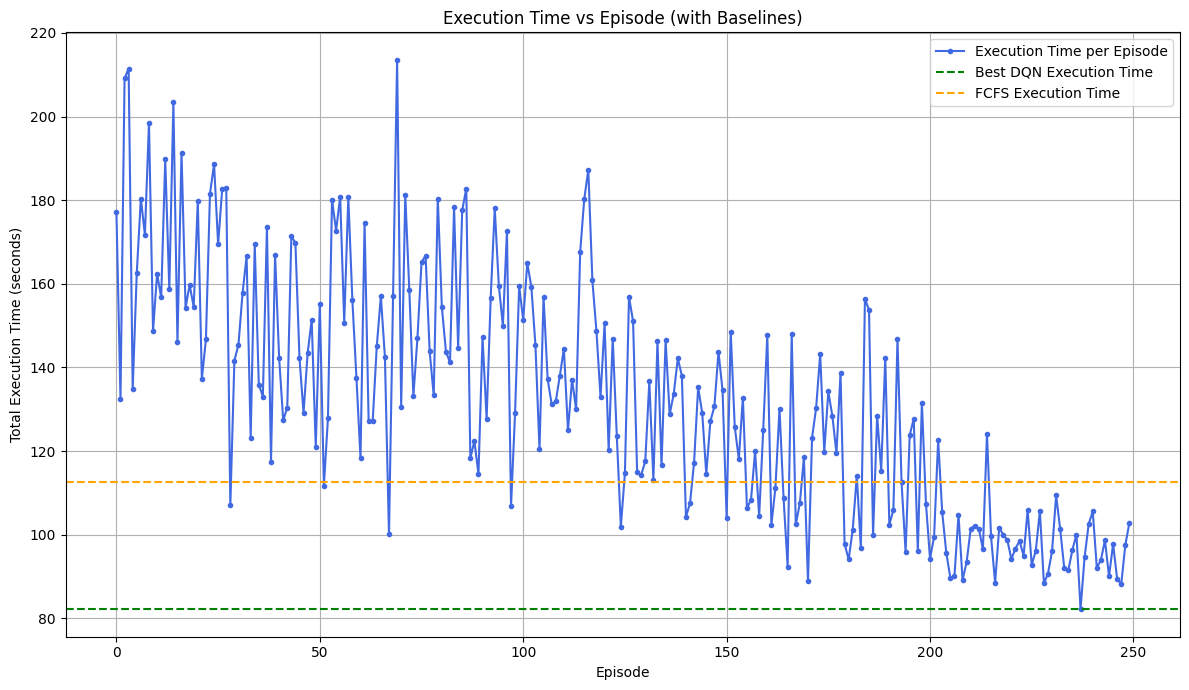

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 7))
plt.plot(execution_times_history, label='Execution Time per Episode', color='royalblue', marker='o', markersize=3)

plt.axhline(best_execution_time, color='green', linestyle='--', label='Best DQN Execution Time')
plt.axhline(fcfs_execution_time, color='orange', linestyle='--', label='FCFS Execution Time')

# Labels and title
plt.xlabel("Episode")
plt.ylabel("Total Execution Time (seconds)")
plt.title("Execution Time vs Episode (with Baselines)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


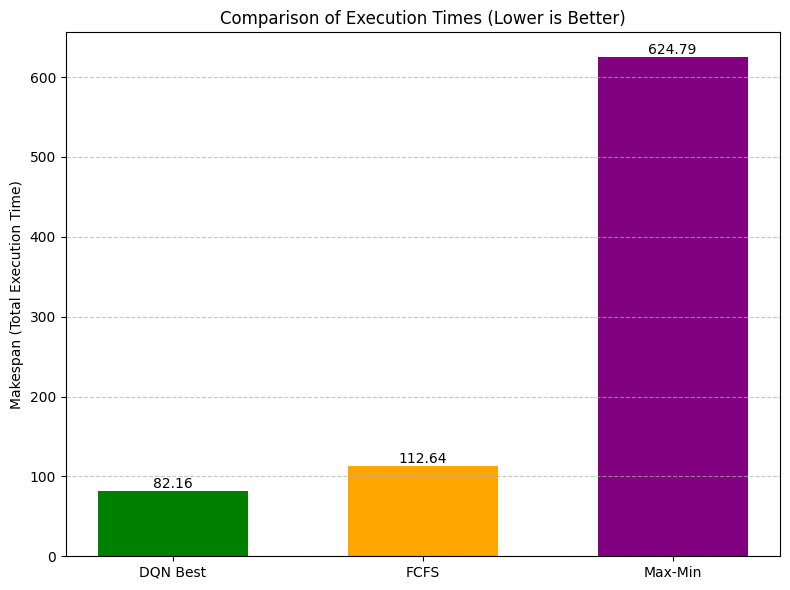

In [ ]:
import matplotlib.pyplot as plt

# Data to plot
labels = ['DQN Best', 'FCFS', 'Max-Min']
execution_times = [best_execution_time, fcfs_execution_time, max_min_execution_time]
colors = ['green', 'orange', 'purple']

# Create bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, execution_times, color=colors, width=0.6)

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Labels and title
plt.title('Comparison of Execution Times (Lower is Better)')
plt.ylabel('Makespan (Total Execution Time)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


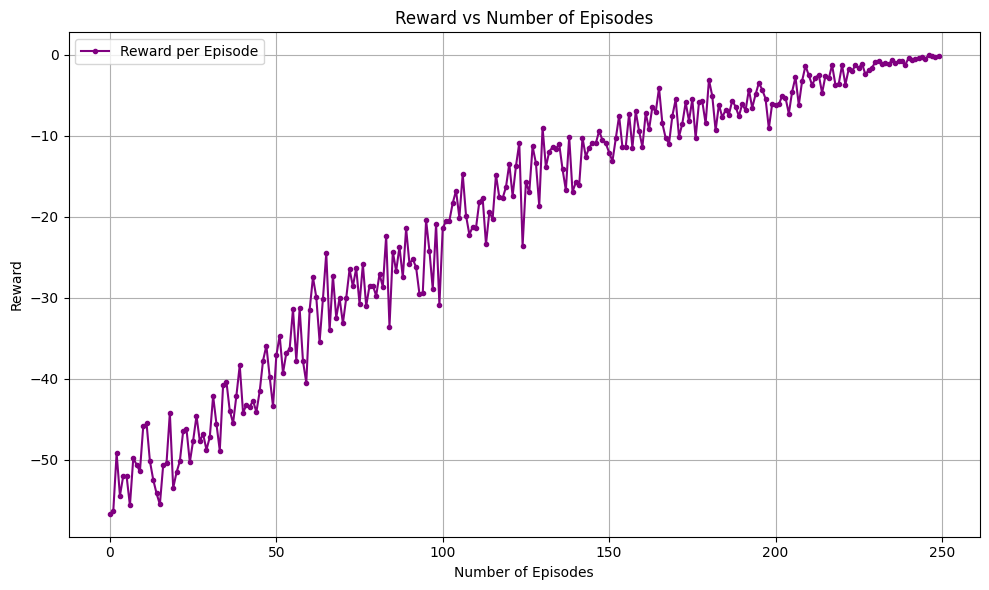

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(reward_history, label='Reward per Episode', color='purple', marker='o', markersize=3)
plt.xlabel("Number of Episodes")
plt.ylabel("Reward")
plt.title("Reward vs Number of Episodes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()